In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load and clean new dataset (Around 8gb)  --- Skip if provided with proccessed dataset

In [ ]:
# Dowload dataset via this link: https://catalog.data.gov/dataset/mta-subway-hourly-ridership-2017-2019

metro_hourly = pd.read_csv('../data/MTA_Subway_Hourly_Ridership__2017-2019.csv')
metro_hourly = metro_hourly[metro_hourly['transit_mode'] == 'subway']


# add datetime and filter to 2018
metro_hourly['timestamp'] = pd.to_datetime(metro_hourly['transit_timestamp'])
metro_hourly = metro_hourly[metro_hourly['timestamp'].dt.year == 2018]


# First we get all unique stations
metro_stations = metro_hourly[['station_complex_id', 'latitude', 'longitude']]
metro_stations.loc[:, 'station_complex_id'] = metro_stations['station_complex_id'].astype(str)
metro_stations = metro_stations.drop_duplicates(subset=['station_complex_id'])
# Now clean the original dataset
# group by hour and station complex id  (station id is only one statino one line, complex id aggregates multiple lines at one station)
metro_hourly = metro_hourly.groupby(['timestamp', 'station_complex_id'])[['ridership', 'transfers']].sum().reset_index()
metro_hourly['total_ridership'] = metro_hourly['ridership'] - metro_hourly['transfers']
metro_hourly['station_id'] = metro_hourly['station_complex_id']

# clean columns
metro_hourly = metro_hourly[['timestamp', 'station_id', 'total_ridership']]

metro_stations.to_csv("../data/processed_metro_stations.csv")
metro_hourly.to_csv("../data/processed_metro_hourly.csv")

C:\Users\fabia\AppData\Local\Temp\ipykernel_15556\2091324859.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  metro_hourly = pd.read_csv('../data/MTA_Subway_Hourly_Ridership__2017-2019.csv')
C:\Users\fabia\AppData\Local\Temp\ipykernel_15556\2091324859.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  metro_hourly['timestamp'] = pd.to_datetime(metro_hourly['transit_timestamp'])


Load data and get overview via head() calls

In [3]:
metro_stations = pd.read_csv(("../data/processed_metro_stations.csv"))
metro_stations.drop(columns=['Unnamed: 0'], inplace=True)
metro_stations.head()

,station_complex_id,latitude,longitude
0,341,40.671986,-73.964380
1,622,40.713240,-74.003400
2,176,40.686110,-73.973946
3,369,40.828583,-73.879160
4,293,40.889248,-73.898580


In [4]:
metro_hourly = pd.read_csv(("../data/processed_metro_hourly.csv"))
metro_hourly.drop(columns=['Unnamed: 0'], inplace=True)
metro_hourly['timestamp'] = pd.to_datetime(metro_hourly['timestamp'])
metro_hourly.dtypes

timestamp          datetime64[ns]
station_id                  int64
total_ridership             int64
dtype: object

In [5]:
bike_trips = pd.read_csv('../data/processed_trips_2018.csv')
bike_pickups = bike_trips[['start_station_id','pickup_day','pickup_hour']]
bike_dropoffs = bike_trips[['end_station_id','dropoff_day','dropoff_hour']]


bike_pickups = bike_pickups.rename(columns={"start_station_id": "station_id", "pickup_day": "day", "pickup_hour": "hour"})
bike_dropoffs = bike_dropoffs.rename(columns={"end_station_id": "station_id", "dropoff_day": "day", "dropoff_hour": "hour"})

bike_trips_all = pd.concat([bike_pickups, bike_dropoffs])

bike_trips_hourly = bike_trips_all.groupby(['station_id', 'day', 'hour']).size().reset_index(name='trip_count')
bike_trips_hourly['timestamp'] = pd.to_datetime(bike_trips_hourly['day'].astype(str) + ' ' + bike_trips_hourly['hour'].astype(str) + ':00:00')
bike_trips_hourly = bike_trips_hourly[["timestamp", 'station_id', 'trip_count']]
bike_trips_hourly.head()

,timestamp,station_id,trip_count
0,2018-01-01 11:00:00,72.0,2
1,2018-01-01 12:00:00,72.0,1
2,2018-01-01 13:00:00,72.0,2
3,2018-01-01 15:00:00,72.0,3
4,2018-01-01 16:00:00,72.0,1


In [6]:
bike_stations = pd.read_csv('../data/processed_stations_2018.csv')
bike_stations.head()

,station_id,station_latitude,station_longitude,category
0,315.0,40.703554,-74.006702,both
1,3224.0,40.739974,-74.005139,both
2,386.0,40.714948,-74.002345,both
3,466.0,40.743954,-73.991449,both
4,438.0,40.727791,-73.985649,both


IN this section we know want to encode the distance measurements for the bike station with the help of the metro_stations data

In [7]:
#
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

In [8]:
# augment bike stations to include distance and and closest metro stop, has_metro means that metro stop is reachable in 200m
bike_stations['metro_stop'] = None
bike_stations["has_metro"] = False
bike_stations['closest_metro'] = 10000.0

for bike_index, bike_row in bike_stations.iterrows():
    min_dist = float('inf')
    nearest_metro_id = None
    
    for metro_index, metro_row in metro_stations.iterrows():
        dist = haversine_distance(bike_row['station_latitude'], bike_row['station_longitude'], metro_row['latitude'], metro_row['longitude'])
        
        if dist < min_dist:
            min_dist = dist
            nearest_metro_id = metro_row['station_complex_id']
    
    bike_stations.at[bike_index, 'closest_metro'] = min_dist
    bike_stations.at[bike_index, 'metro_stop'] = nearest_metro_id
    
    if min_dist <= 0.2:
        bike_stations.at[bike_index, "has_metro"] = True

Lets do a first analysis on the bike statins that are within 200m of a subway station

In [9]:
bike_stations.groupby('has_metro').agg('count')['station_id'].head()

has_metro
False    623
True     226
Name: station_id, dtype: int64

OK, we can see that about 246 bike stations have a suway station very close, lets plot this

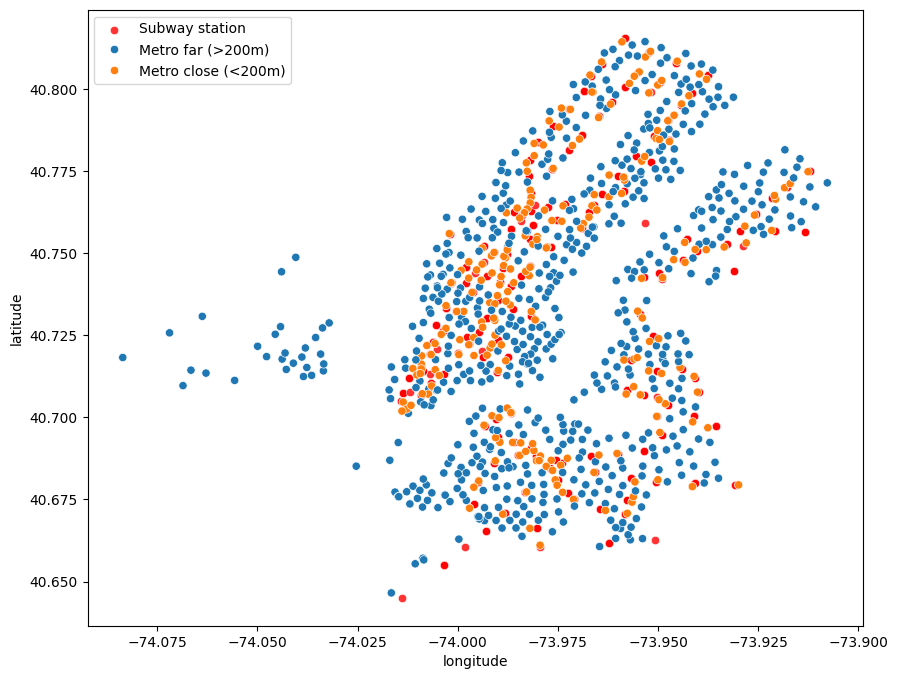

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=metro_stations.merge(bike_stations, "inner",left_on="station_complex_id", right_on="metro_stop"), x='longitude', y='latitude', label="Subway station", color='red', alpha=0.8)
sns.scatterplot(data=bike_stations, x='station_longitude', y='station_latitude', hue=bike_stations['has_metro'].rename("").map({True: 'Metro close (<200m)', False: 'Metro far (>200m)'}))
plt.show()

Now lets see how this impacts the bike pickups and dropoffs over the day  
We will join the station information with the bike trips

In [11]:
bike_trips_hourly.head()

,timestamp,station_id,trip_count
0,2018-01-01 11:00:00,72.0,2
1,2018-01-01 12:00:00,72.0,1
2,2018-01-01 13:00:00,72.0,2
3,2018-01-01 15:00:00,72.0,3
4,2018-01-01 16:00:00,72.0,1


In [12]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.6, float('inf')]
labels = ['< 0.1 km', '0.1 - 0.2 km', '0.2 - 0.3 km', '0.3 - 0.4 km', '0.4 - 0.6 km', '> 0.6 km']
bike_stations['distance_bucket'] = pd.cut(bike_stations['closest_metro'], bins=bins, labels=labels)

#Build scaffold to include 0 values
all_stations = bike_stations['station_id'].unique()
full_time_range = pd.date_range(start=bike_trips_hourly['timestamp'].min(), end=bike_trips_hourly['timestamp'].max(), freq='H')
scaffold = pd.MultiIndex.from_product([all_stations, full_time_range], names=['station_id', 'timestamp']).to_frame(index=False)
combined = scaffold.merge(bike_trips_hourly, left_on=["station_id", "timestamp"],right_on=["station_id", "timestamp"], how="left")
combined['trip_count'] = combined['trip_count'].fillna(0)
combined = combined.merge(bike_stations[['station_id','closest_metro', 'metro_stop', 'has_metro','distance_bucket']], left_on="station_id", right_on="station_id")
combined['hour'] = combined['timestamp'].dt.hour
combined["date"] = combined ["timestamp"].dt.date
combined.head()

C:\Users\fabia\AppData\Local\Temp\ipykernel_15556\1526290820.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=bike_trips_hourly['timestamp'].min(), end=bike_trips_hourly['timestamp'].max(), freq='H')


,station_id,timestamp,trip_count,closest_metro,metro_stop,has_metro,distance_bucket,hour,date
0,315.0,2018-01-01 00:00:00,2.0,0.415639,333.0,False,0.4 - 0.6 km,0,2018-01-01
1,315.0,2018-01-01 01:00:00,0.0,0.415639,333.0,False,0.4 - 0.6 km,1,2018-01-01
2,315.0,2018-01-01 02:00:00,0.0,0.415639,333.0,False,0.4 - 0.6 km,2,2018-01-01
3,315.0,2018-01-01 03:00:00,0.0,0.415639,333.0,False,0.4 - 0.6 km,3,2018-01-01
4,315.0,2018-01-01 04:00:00,0.0,0.415639,333.0,False,0.4 - 0.6 km,4,2018-01-01


In [13]:
bike_stations.groupby("distance_bucket").size()

C:\Users\fabia\AppData\Local\Temp\ipykernel_15556\2116204469.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bike_stations.groupby("distance_bucket").size()


distance_bucket
< 0.1 km         92
0.1 - 0.2 km    134
0.2 - 0.3 km    165
0.3 - 0.4 km    149
0.4 - 0.6 km    171
> 0.6 km        138
dtype: int64

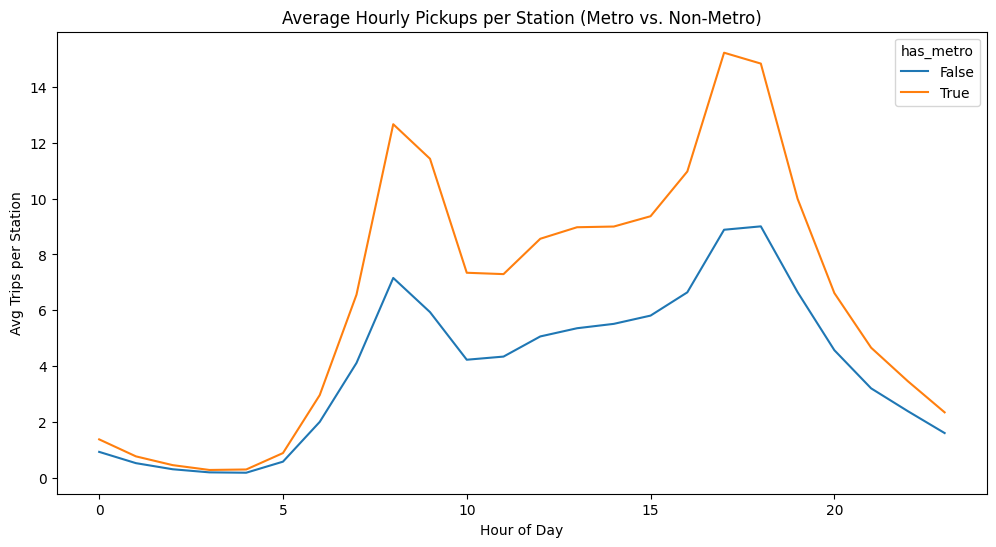

In [14]:
avg_curve = combined.groupby(['has_metro', 'hour'])['trip_count'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=avg_curve, 
    x='hour', 
    y='trip_count', 
    hue='has_metro'
)
plt.title("Average Hourly Pickups per Station (Metro vs. Non-Metro)")
plt.ylabel("Avg Trips per Station")
plt.xlabel("Hour of Day")
plt.show()

Very interesting indeed. Lets make this analysis a little bit more granular. We will create 6 buckets 

C:\Users\fabia\AppData\Local\Temp\ipykernel_15556\1512223110.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_curve = combined.groupby(['distance_bucket', 'hour'])['trip_count'].mean().reset_index()


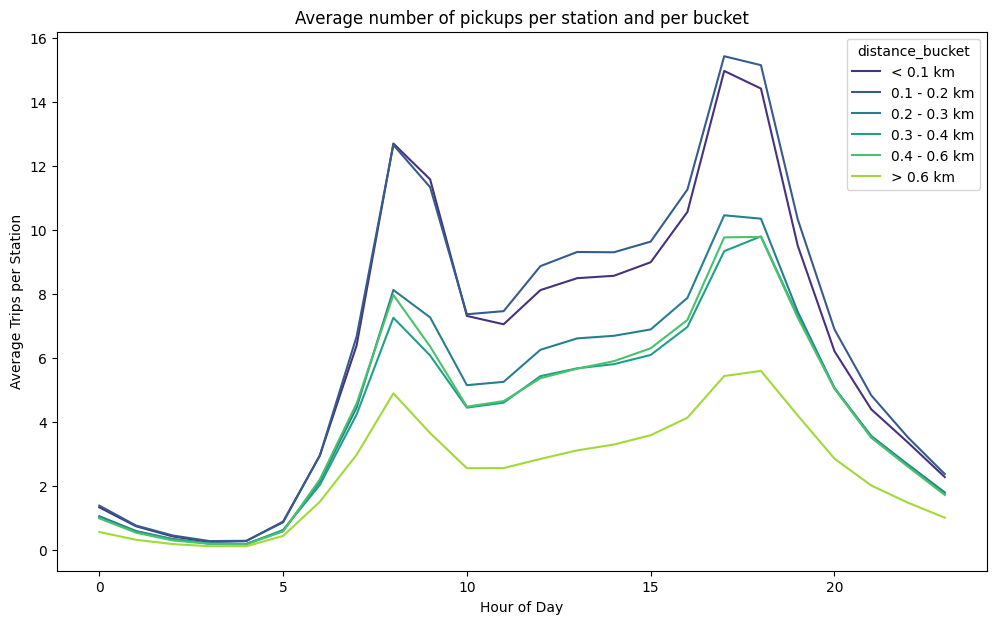

In [15]:
avg_curve = combined.groupby(['distance_bucket', 'hour'])['trip_count'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=avg_curve, 
    x='hour', 
    y='trip_count', 
    hue='distance_bucket', 
    palette='viridis'
)
plt.title('Average number of pickups per station and per bucket')
plt.ylabel('Average Trips per Station')
plt.xlabel('Hour of Day')
plt.show()

C:\Users\fabia\AppData\Local\Temp\ipykernel_15556\2069569124.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_curve = combined.groupby(['distance_bucket', 'date'])['trip_count'].mean().reset_index()
C:\Users\fabia\AppData\Local\Temp\ipykernel_15556\2069569124.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_curve['trip_count_7d_ma'] = avg_curve.groupby('distance_bucket')['trip_count'].transform(lambda x: x.rolling(window=7).mean())


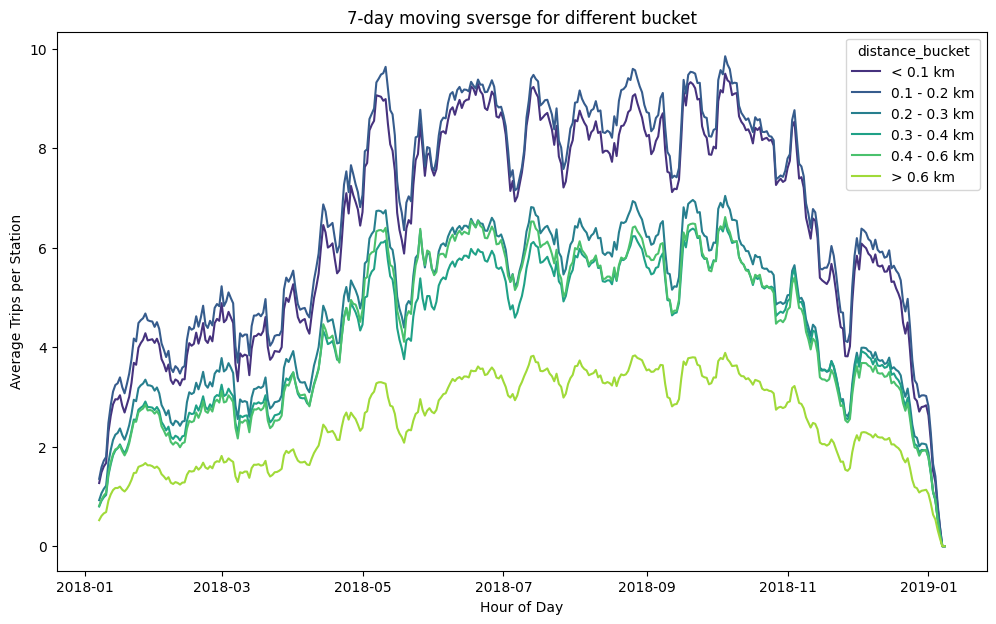

In [16]:
avg_curve = combined.groupby(['distance_bucket', 'date'])['trip_count'].mean().reset_index()
avg_curve = avg_curve.sort_values(by=['distance_bucket', 'date']) # Ensure data is sorted by date
avg_curve['trip_count_7d_ma'] = avg_curve.groupby('distance_bucket')['trip_count'].transform(lambda x: x.rolling(window=7).mean())

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=avg_curve, 
    x='date', 
    y='trip_count_7d_ma', 
    hue='distance_bucket', 
    palette='viridis'
)
plt.title('7-day moving sversge for different bucket')
plt.ylabel('Average Trips per Station')
plt.xlabel('Hour of Day')
plt.show()

We can see that there is a clear relationship between the distance to the metro and the pickup numbers.  
Now lets try to quantify that using a Linear regression.  
We will also add the number of commuters from the nearest metro station as an additional regressor

In [17]:
metro_hourly.head()

,timestamp,station_id,total_ridership
0,2018-01-01,1,108
1,2018-01-01,10,507
2,2018-01-01,100,24
3,2018-01-01,101,142
4,2018-01-01,103,100


In [18]:
df_all = combined.merge(metro_hourly, how="left", left_on=['timestamp', 'metro_stop'], right_on=['timestamp', 'station_id'])
df_all['total_ridership'] = df_all['total_ridership'] / 1000
df_all['trip_count'] = df_all['trip_count']
df_all = df_all.dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7016683 entries, 12 to 7587335
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   station_id_x     float64       
 1   timestamp        datetime64[ns]
 2   trip_count       float64       
 3   closest_metro    float64       
 4   metro_stop       object        
 5   has_metro        bool          
 6   distance_bucket  category      
 7   hour             int32         
 8   date             object        
 9   station_id_y     float64       
 10  total_ridership  float64       
dtypes: bool(1), category(1), datetime64[ns](1), float64(5), int32(1), object(2)
memory usage: 521.9+ MB


In [19]:
regressor_year = df_all.groupby('station_id_x').agg(total_ridership=('total_ridership', 'sum'), closest_metro=('closest_metro', 'mean'), trip_count=('trip_count', 'sum')).reset_index()
regressor_year.head()

,station_id_x,total_ridership,closest_metro,trip_count
0,72.0,6349.823,0.857033,76986.0
1,79.0,1748.424,0.029520,54752.0
2,82.0,9004.299,0.356499,20673.0
3,83.0,13776.192,0.085163,26955.0
4,119.0,6597.266,0.685658,7044.0


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

regressor_year = regressor_year.sample(frac=1, random_state=42)
X = regressor_year[["total_ridership", 'closest_metro']]
y = regressor_year["trip_count"]
split = int(len(X)*2/3)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

model = LinearRegression()
model.fit(X_train,y_train)

print("Coefficients:", model.coef_)
print("Ridership in thousand, distance to metro in km")
print("Intercept:", model.intercept_)
print(split, len(X_train), len(X_test))

Coefficients: [ 1.65864773e+00 -1.30800813e+04]
Ridership in thousand, distance to metro in km
Intercept: 33049.17652396849
565 565 283



Model Performance Metrics
MAE (Mean Absolute Error):  28076.61
MSE (Mean Squared Error):   1516724228.58
RMSE (Root Mean Sq Error):  38945.14
R² Score:                   0.2246
MAPE (Mean Abs % Error):    33227915614490.63%



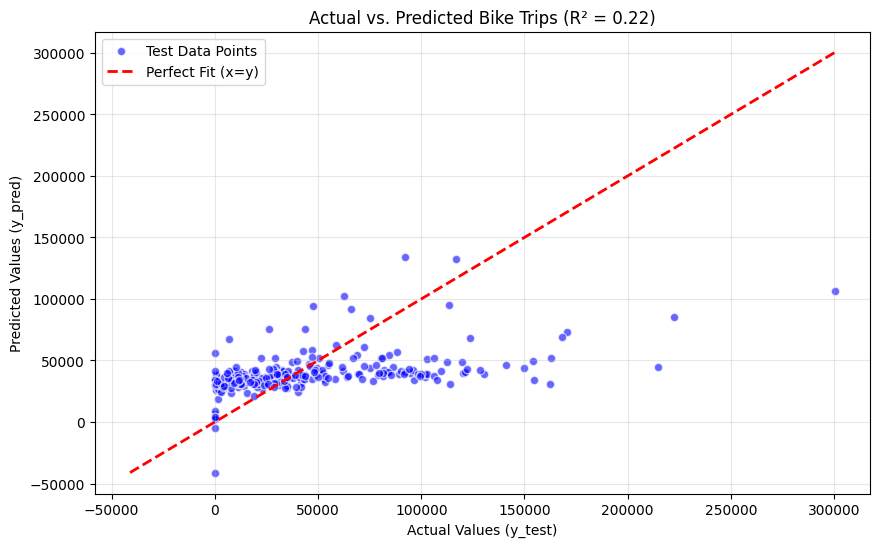

In [21]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

print("\n" + "="*30)
print("Model Performance Metrics")
print("="*30)
print(f"MAE (Mean Absolute Error):  {mae:.2f}")
print(f"MSE (Mean Squared Error):   {mse:.2f}")
print(f"RMSE (Root Mean Sq Error):  {rmse:.2f}")
print(f"R² Score:                   {r2:.4f}")
print(f"MAPE (Mean Abs % Error):    {mape:.2f}%")
print("="*30 + "\n")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='w', label='Test Data Points')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit (x=y)')
plt.title(f'Actual vs. Predicted Bike Trips (R² = {r2:.2f})')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The yearly rgression gave us some info, but we would like to go more granular. Lets do this on hourly data.

In [22]:
regressor_hourly = df_all.copy()
regressor_hourly = regressor_hourly.sample(frac=1, random_state=42)
X = regressor_hourly[["total_ridership", 'closest_metro']]
y = regressor_hourly["trip_count"]
split = int(len(X)*2/3)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

model = LinearRegression()
model.fit(X_train,y_train)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print(split, len(X_train), len(X_test))

Coefficients: [ 2.30438084 -1.66962279]
Intercept: 3.5643136036639786
4677788 4677788 2338895



Model Performance Metrics
MAE (Mean Absolute Error):  4.78
MSE (Mean Squared Error):   69.90
RMSE (Root Mean Sq Error):  8.36
R² Score:                   0.1807
MAPE (Mean Abs % Error):    1488775440347.04%



C:\Users\fabia\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


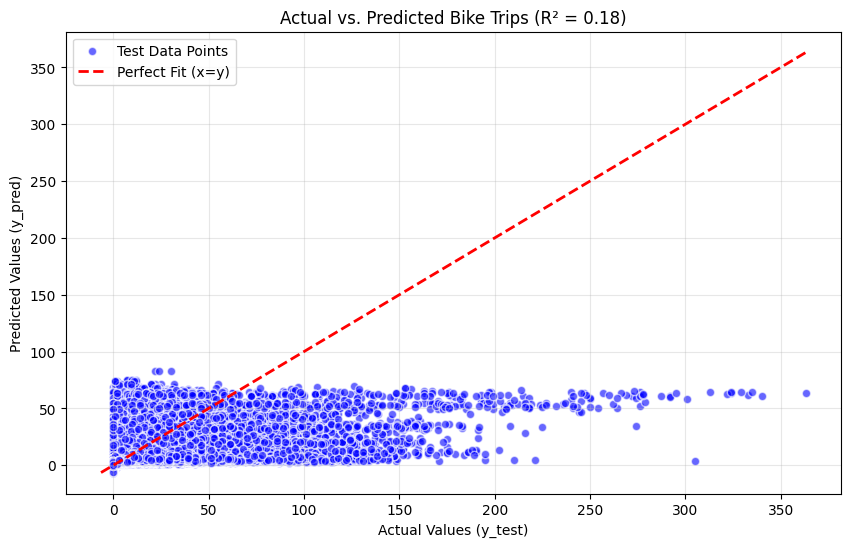

In [23]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

print("\n" + "="*30)
print("Model Performance Metrics")
print("="*30)
print(f"MAE (Mean Absolute Error):  {mae:.2f}")
print(f"MSE (Mean Squared Error):   {mse:.2f}")
print(f"RMSE (Root Mean Sq Error):  {rmse:.2f}")
print(f"R² Score:                   {r2:.4f}")
print(f"MAPE (Mean Abs % Error):    {mape:.2f}%")
print("="*30 + "\n")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='w', label='Test Data Points')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit (x=y)')
plt.title(f'Actual vs. Predicted Bike Trips (R² = {r2:.2f})')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Again not very compelling results from a benchmark perspective. However we do see that coeffcients are wuite high. We do see an effect here.

In [24]:
regressor_hourly = df_all.copy()
regressor_hourly["day_of_week"] = regressor_hourly["timestamp"].dt.weekday
regressor_hourly["month"] = regressor_hourly["timestamp"].dt.month
regressor_hourly['trip_counts_lag_1h'] = regressor_hourly['trip_count'].shift(1)
regressor_hourly['trip_counts_lag_2h'] = regressor_hourly['trip_count'].shift(2)
regressor_hourly['trip_counts_lag_24h'] = regressor_hourly['trip_count'].shift(24)
regressor_hourly['trip_counts_lag_7days'] = regressor_hourly['trip_count'].shift(24*7)

regressor_hourly.dropna(inplace=True)

In [25]:
regressor_hourly = regressor_hourly.sample(frac=1, random_state=42)
X = regressor_hourly[["total_ridership", 'closest_metro', 'day_of_week', 'month', 'trip_counts_lag_1h', 'trip_counts_lag_2h', 'trip_counts_lag_24h', 'trip_counts_lag_7days']]
y = regressor_hourly["trip_count"]
split = int(len(X)*2/3)

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

model = LinearRegression()
model.fit(X_train,y_train)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print(split, len(X_train), len(X_test))

Coefficients: [ 0.30544547 -0.08235653 -0.04890152 -0.00547094  0.48233202 -0.05223741
  0.23589502  0.26916634]
Intercept: 0.2673858751471192
4677676 4677676 2338839



Model Performance Metrics
MAE (Mean Absolute Error):  2.32
MSE (Mean Squared Error):   20.43
RMSE (Root Mean Sq Error):  4.52
R² Score:                   0.7619
MAPE (Mean Abs % Error):    318804983336.63%



C:\Users\fabia\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


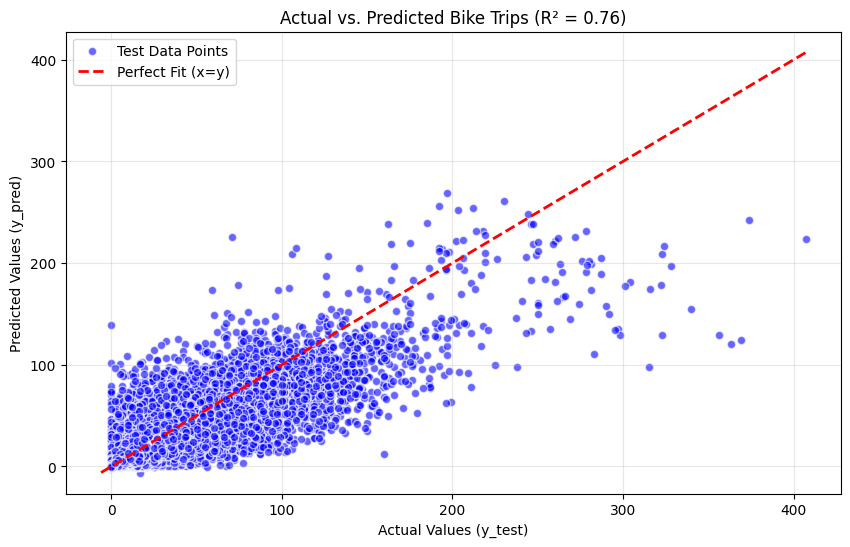

In [26]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

print("\n" + "="*30)
print("Model Performance Metrics")
print("="*30)
print(f"MAE (Mean Absolute Error):  {mae:.2f}")
print(f"MSE (Mean Squared Error):   {mse:.2f}")
print(f"RMSE (Root Mean Sq Error):  {rmse:.2f}")
print(f"R² Score:                   {r2:.4f}")
print(f"MAPE (Mean Abs % Error):    {mape:.2f}%")
print("="*30 + "\n")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='w', label='Test Data Points')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit (x=y)')
plt.title(f'Actual vs. Predicted Bike Trips (R² = {r2:.2f})')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

R2 Score: 0.8020
MAE: 2.13


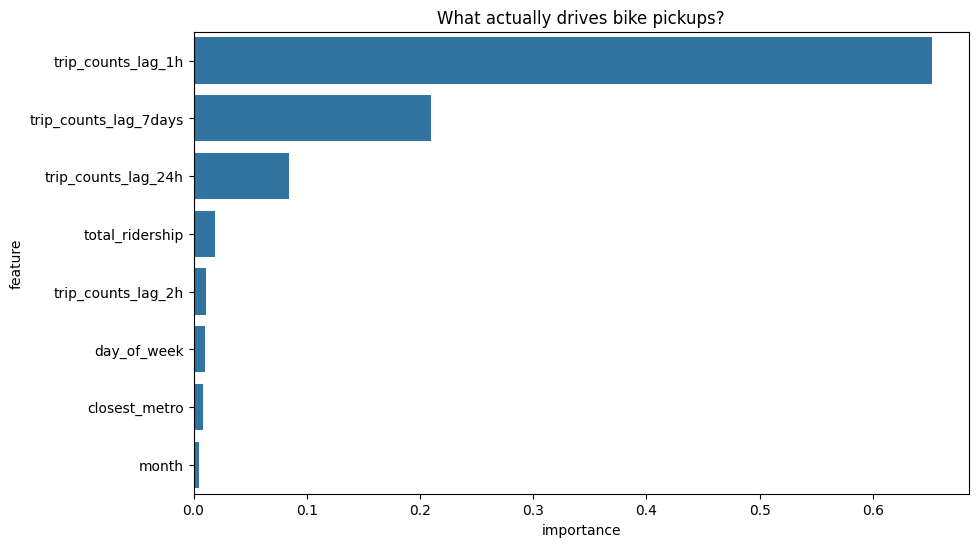

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = regressor_hourly[["total_ridership", 'closest_metro', 'day_of_week', 'month', 'trip_counts_lag_1h', 'trip_counts_lag_2h', 'trip_counts_lag_24h', 'trip_counts_lag_7days']]
y = regressor_hourly["trip_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")


importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance, x='importance', y='feature')
plt.title("What actually drives bike pickups?")
plt.show()

In [28]:
importance

,feature,importance
4,trip_counts_lag_1h,0.651980
7,trip_counts_lag_7days,0.210109
6,trip_counts_lag_24h,0.084488
0,total_ridership,0.019129
5,trip_counts_lag_2h,0.011129
2,day_of_week,0.010299
1,closest_metro,0.008147
3,month,0.004718


R2 Score: 0.6737
MAE: 2.67


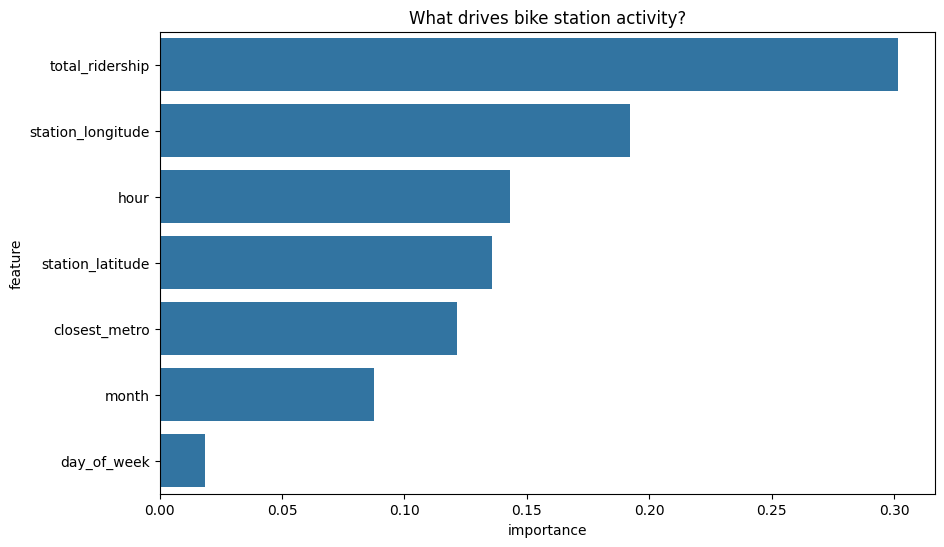

In [29]:
features = [
    "total_ridership", 
    "hour", 
    "day_of_week", 
    "month", 
    "closest_metro", 
    "station_latitude", 
    "station_longitude"
]


new_df = regressor_hourly.merge(bike_stations[['station_id', "station_latitude", 'station_longitude']], how="left", left_on='station_id_x', right_on='station_id')
new_df = new_df.dropna()

X = new_df[features]
y = new_df['trip_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)

# 4. Evaluate
y_pred = rf.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")


importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance, x='importance', y='feature')
plt.title("What drives bike station activity?")
plt.show()